In [4]:
import pandas as pd
from tqdm import tqdm
from scipy import stats
import numpy as np
import requests

/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [15]:
# 所有台股code
def stock_code_init_tw():
    '''
    https://www.twse.com.tw/zh/trading/historical/bwibbu-day.html   
    https://www.twse.com.tw/rwd/zh/afterTrading/BWIBBU_d?date=20240809&selectType=ALL&response=json
    '''

    uri = "https://www.twse.com.tw/rwd/zh/afterTrading/BWIBBU_d?date=20240809&selectType=ALL&response=json"
    res = requests.get(uri)
    data = res.json()['data']
    code = [i[0] for i in data]
    cname = [i[1] for i in data]
    listed = ["TW"] * len(code)
    df = pd.DataFrame({
        "code": code,
        "cname": cname,
        "listed": listed
    })
    return df
code_list = list(stock_code_init_tw()['code'].values)
code_list = [i + '.TW' for i in code_list]

benchmark_index = "^TWII"
code_list += [benchmark_index]

In [47]:
# 台股收盤價
import yfinance as yf
df = yf.download(code_list, start='2024-11-01', rounding=2, interval='5m')
res = df['Close'].dropna(how='all', axis=1)

[*********************100%***********************]  1017 of 1017 completed

1 Failed download:
['1701.TW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [48]:
def backtest_code(res, code, rolling=5, benchmark = 2, benchmark_index="^TWII"):
    pivoted = res[[code, benchmark_index]]
    pivoted.ffill()
    ret = pivoted.pct_change(fill_method=None)
    try:
        ret['stock_price'] = pivoted[code]
        ret['ret_diff'] = ret[code] - ret[benchmark_index]
        # type 1
        # ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
        # ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
        # ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
        
        # type 2
        ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
        ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
        ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

        ret[code] = (1 + ret[code]).cumprod() - 1

        ret['index'] = [i for i in range(len(ret))]

        # check direction
        ret['lag10'] = ret['stock_price'].shift(-4)
        ret['change_stock'] = (ret['lag10'] - ret[code])/ret[code]
        ret['direction'] = ret.apply(lambda x: -1 if x['stock_price'] - x['lag10'] > 0 else 1, axis=1)

        # check if the direction are the same, if not, tned to not being a mean reversion
        ret['lag10_twii'] = ret[benchmark_index].shift(-4)
        ret['change_twii'] = (ret['lag10_twii'] - ret[benchmark_index])/ret[benchmark_index]
        ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
        ret['filter_2'] = ret.apply(lambda x: 1 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)

        # check raise
        ret[f'{code}_lag60'] = ret['stock_price'].shift(-12)
        ret['target_60mins'] = (ret[f'{code}_lag60'] - ret['stock_price'])/ret['stock_price'] * ret['direction']
        ret = ret[(ret['stdize_ret_diff'] >= benchmark) & (ret['filter_1'] == 1) & (ret['filter_2'] == 1)][['target_60mins', 'stdize_ret_diff']].dropna()
        ret['code'] = code
        return ret
    except:
        print(pivoted)

In [49]:
dfs = []
for code in tqdm(list(res.columns)):
    if code == benchmark_index: continue
    df = backtest_code(res, code, rolling=5, benchmark_index=benchmark_index)
    if len(df) == 0: continue
    dfs.append(df)
final = pd.concat(dfs)


100%|██████████| 1016/1016 [00:23<00:00, 42.68it/s]


In [50]:
# p-value: 平均?分鐘後收益有沒有顯著大於某個數字
import numpy as np
import pandas as pd
from scipy import stats
# to test if return after 60 mins are greater than {test}
print('測試有沒有顯著大於 & p-value(<0.05: 有) & t值')
for test in range(0, 15, 1):
    test /= 1000
    final = pd.concat(dfs)
    final = final[final['target_60mins'] != 0.0]
    final['target_60mins'] = final['target_60mins'] - test
    mean = final['target_60mins'].mean()
    n = len(final)
    s = final['target_60mins'].std()

    t_statistic = (mean - 0.0) / (s / np.sqrt(n))

    t_stat, p_value = stats.ttest_1samp(final['target_60mins'], 0.0)

    if t_stat > 0:
        one_tailed_p_value = p_value / 2
    else:
        one_tailed_p_value = 1 - (p_value / 2)

    print(f"{test}              {np.round(one_tailed_p_value, 2)}          &  {np.round(t_statistic, 2)}")


測試有沒有顯著大於 & p-value(<0.05: 有) & t值
0.0              0.0          &  12.02
0.001              0.0          &  10.96
0.002              0.0          &  9.89
0.003              0.0          &  8.82
0.004              0.0          &  7.76
0.005              0.0          &  6.69
0.006              0.0          &  5.63
0.007              0.0          &  4.56
0.008              0.0          &  3.5
0.009              0.01          &  2.43
0.01              0.09          &  1.37
0.011              0.38          &  0.3
0.012              0.78          &  -0.77
0.013              0.97          &  -1.83
0.014              1.0          &  -2.9


單隻測試

In [55]:
code = '3661.TW'
rolling = 5
ret = res[[code, benchmark_index]].pct_change()
ret['ret_diff'] = ret[code] - ret[benchmark_index]
# type 1
# ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
# ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
# ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])

# type 2
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

ret[code] = (1 + ret[code]).cumprod() - 1

ret['index'] = [i for i in range(len(ret))]

# check direction
ret['lag10'] = ret[code].shift(-4)
ret['change_stock'] = (ret['lag10'] - ret[code])/ret[code]

# check if the direction are the same, if not, tned to not being a mean reversion
ret['lag10_twii'] = ret[benchmark_index].shift(-4)
ret['change_twii'] = (ret['lag10_twii'] - ret[benchmark_index])/ret[benchmark_index]
ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
ret['filter_2'] = ret.apply(lambda x: 0 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-12)
ret['stock_price'] = res[code]
ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = (np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3)) * ret['direction']

# ret['signal_defineby_prev_ret'] = 
# specific print
ret.set_index('index', inplace=True, drop=False)
# start = -54 # -268
ret[ret['stdize_ret_diff'] >= 2]

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_81529/3880823858.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = res[[code, benchmark_index]].pct_change()


Ticker,3661.TW,^TWII,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,lag10,change_stock,lag10_twii,change_twii,filter_1,filter_2,3661.TW_lag60,stock_price,direction,target_60mins
index,,,,,,,,,,,,,,,,,
54,0.079012,0.002969,0.070741,0.031479,0.014746,17.626786,54,0.074074,-0.062500,-0.000355,-1.119568,0,0,0.083951,2185.0,-1,-0.063
55,0.074074,0.001250,-0.005826,0.031752,0.014392,6.419731,55,0.081481,0.100000,0.000004,-0.996858,0,0,0.076543,2175.0,1,0.033
56,0.064198,-0.000229,-0.008967,0.032996,0.012599,7.115998,56,0.086420,0.346154,-0.000096,-0.580271,0,0,0.079012,2155.0,1,0.231
57,0.071605,0.002776,0.004185,0.033053,0.012408,2.718052,57,0.081481,0.137931,0.000403,-0.854915,0,0,0.076543,2170.0,1,0.069
58,0.074074,-0.000355,0.002659,0.032995,0.012558,3.266268,58,0.081481,0.100000,-0.002071,4.833183,0,0,0.076543,2175.0,1,0.033
216,0.222222,0.002498,0.024473,0.010633,0.005494,2.018029,216,0.207407,-0.066667,-0.000564,-1.225902,0,0,0.217284,2475.0,-1,0.022
217,0.207407,0.002070,-0.014191,0.013888,0.002565,2.327043,217,0.195062,-0.059524,-0.001227,-1.592916,0,0,0.212346,2445.0,-1,-0.024
1188,0.096296,0.010255,-0.025776,0.011969,-0.004734,2.518374,1188,0.096296,0.000000,-0.001751,-1.170729,0,0,0.093827,2220.0,1,-0.026
1243,0.123457,0.000099,0.024675,0.011623,0.005450,2.234668,1243,0.150617,0.220000,0.001418,13.268278,0,0,0.162963,2275.0,1,0.320


1404


/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_81529/3640292363.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():


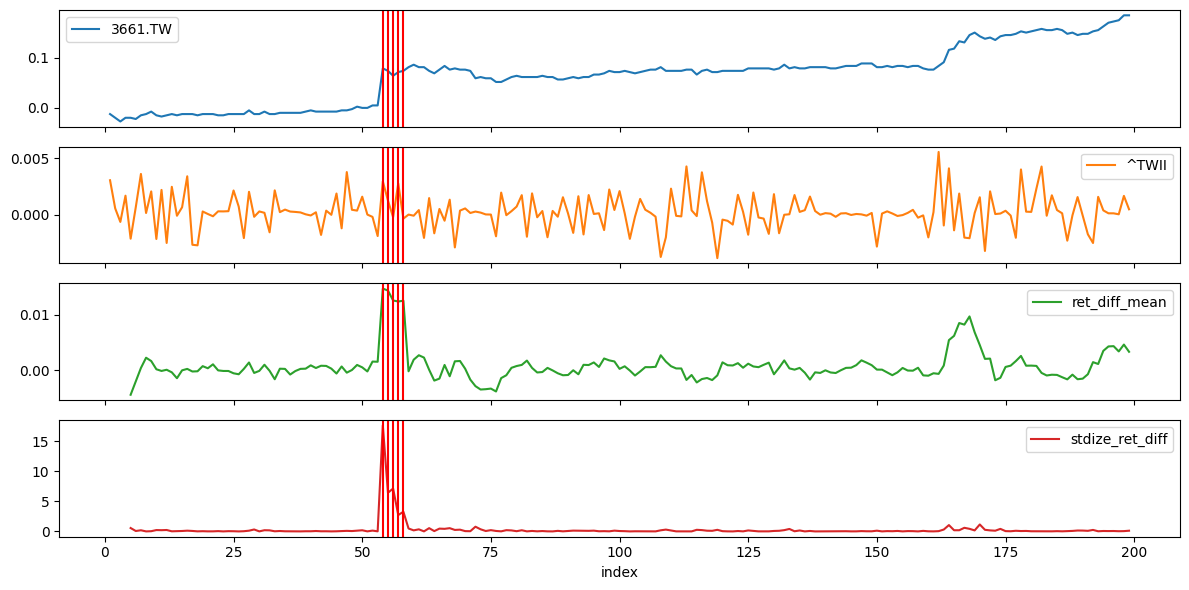

In [57]:
import matplotlib.pyplot as plt
start = 0
end = len(ret)
print(end)
end = 200
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()